In [157]:
from scipy.stats import ks_2samp
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import random
import utils
import sys
import os

In [149]:
def build_dataset(
    videos_dir,
    videos_accs,
    df,
    network,
    number_of_videos=64,
    video_format=".avi",
):
    """
    This function builds the dataset for the training of the model.
    Args:
        videos_dir: the directory containing the videos
        videos_accs: the dictionary containing the accumulators for each layer
        df: the dataframe containing the duration of the black screen for each video (value to predict)
        number_of_videos: the number of videos to use for the training
        video_format: the format of the videos
    """
    # Get all videos
    videos = utils.retrieve_videos(
            videos_dir, number_of_videos=number_of_videos, video_format=video_format
        )

    X, y, patients, stimuli_names = [], [], [], []
    for video in videos:

        if video not in videos_accs.keys():
            continue

        accs = videos_accs[video]
        
        if not network.startswith("DRTANet"):
            # Transform the dictionary into a list
            accs = [accs[layer] for layer in accs.keys()]
        elif network == "DRTANet_final":
            accs = [accs]

        video = video.replace(".avi", "")
        video = video.replace(".", "")

        # Get the trials related to the video : duration of the black screen and participant ID
        durations = df[df["Stimuli_Name"] == video]["BlackScreen_Duration"].values
        ids = df[df["Stimuli_Name"] == video]["Participant"].values

        for duration, id in zip(durations, ids):
            X.append(accs)
            y.append(duration)
            patients.append(id)
            stimuli_names.append(video)
            
    return X, y, patients, stimuli_names

In [150]:
def load_accumulators(NB_VIDEOS, NETWORK):
# Load the accumulators (if already computed) (pickles)
    if not NETWORK.startswith("DRTANet"):
        if (os.path.exists("videos_accs_" + str(NB_VIDEOS) + "_" + str(NETWORK) + ".p")):
            with open("videos_accs_" + str(NB_VIDEOS) + "_" + str(NETWORK) + ".p", "rb") as f:
                videos_accs = pickle.load(f)
                
            return videos_accs
        
        else:
            print("Error: Accumulators not found, please compute accumulators first.")
            sys.exit()
    
    else:
        if NETWORK == "DRTANet_final":
            if (os.path.exists("DRTANet_accs_" + str(NB_VIDEOS) + ".p")):
                with open("DRTANet_accs_" + str(NB_VIDEOS) + ".p", "rb") as f:
                    videos_accs = pickle.load(f)
                    
                return videos_accs
            
            else:
                print("Error: Accumulators not found, please compute accumulators first.")
                sys.exit()
                
        elif NETWORK == "DRTANet_series":
            if (os.path.exists("DRTANet_history_accs_" + str(NB_VIDEOS) + ".p")):
                with open("DRTANet_history_accs_" + str(NB_VIDEOS) + ".p", "rb") as f:
                    videos_accs = pickle.load(f)
                    
                return videos_accs
            
            else:
                print("Error: Accumulators not found, please compute accumulators first.")
                sys.exit()

In [151]:
def generate_distribution(X, Y, model, permute=False):
    
    Y_permute = np.random.permutation(Y) if permute else Y

    X_train, X_test, y_train, y_test = train_test_split(X, Y_permute, test_size=0.2)
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Compute MSE
    mse = np.mean((y_pred - y_test)**2)
    
    return mse

In [152]:
def plot_histograms(scores_shuffled, scores_non_shuffled):

    plt.hist(scores_shuffled, bins=50, alpha=0.5, label='Shuffled')
    plt.show()

    plt.hist(scores_non_shuffled, bins=50, alpha=0.5, label='Non-Shuffled')
    plt.show()

In [153]:
networks = ["DRTANet_final", "resnet18", "efficientnetB0"]
N = 1000
nb_videos = 64
videos_dir = "../../tfe/Videos"
root_dir = ""

scores = {network: {"shuffled": [], "non_shuffled": []} for network in networks}
for network in networks:
    print("Network : " + network)
    
    videos_accs = load_accumulators(nb_videos, network)
    df = utils.read_excel(root_dir,videos_dir)

    model = LassoCV()
    X, Y, _, _ = build_dataset(videos_dir, videos_accs, df, network)
    
    scores_shuffled = []
    scores_non_shuffled = []
    for i in range(N):
        mse = generate_distribution(X, Y, model, permute=True)
        scores_shuffled.append(mse)
        
        mse = generate_distribution(X, Y, model, permute=False)
        scores_non_shuffled.append(mse)
    
    scores[network]["shuffled"] = scores_shuffled
    scores[network]["non_shuffled"] = scores_non_shuffled
print(scores)

Network : DRTANet_final
Number of videos in the directory : 65
Number of videos in the dataframe : 64
Network : resnet18
Number of videos in the directory : 65
Number of videos in the dataframe : 64
Network : efficientnetB0
Number of videos in the directory : 65
Number of videos in the dataframe : 64


/Users/lucienavez/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e+03, tolerance: 1.701e+01
  model = cd_fast.enet_coordinate_descent(
/Users/lucienavez/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.539e+02, tolerance: 1.740e+01
  model = cd_fast.enet_coordinate_descent(
/Users/lucienavez/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

{'DRTANet_final': {'shuffled': [203.58131726009046, 219.05486267018398, 212.8881290672616, 198.34496119449784, 203.74905190102308, 236.85086208023338, 195.5547157569161, 206.5958973463234, 216.60958966157247, 189.93291920739546, 213.20941157635082, 187.4301645729314, 219.88690861944536, 200.31427934016085, 178.31909763518055, 180.49093949224073, 197.80389297215206, 241.31175904433422, 252.4470982106592, 228.04258988433824, 213.434152113173, 212.56245099503033, 202.65978506320985, 206.84122678610504, 213.20969763289142, 171.1450596695941, 218.8632220361403, 155.50699255377876, 240.03813327333194, 199.66874871658925, 229.4782115075417, 211.50719978041658, 212.25046614828523, 214.13634186081947, 173.08327893173515, 179.24556637819873, 195.15790447797934, 228.83294283617036, 228.79335983501466, 178.11491435680458, 201.2683048320871, 226.88503080264337, 183.01618610276336, 207.39434678650292, 185.5762248629753, 182.54543244535046, 213.53492240881047, 243.77542496005475, 217.56960957772233, 

Network : DRTANet_final


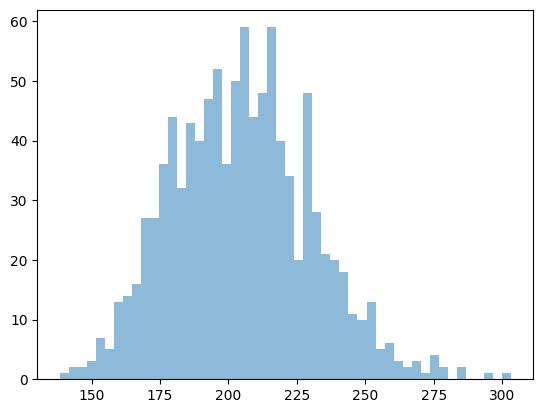

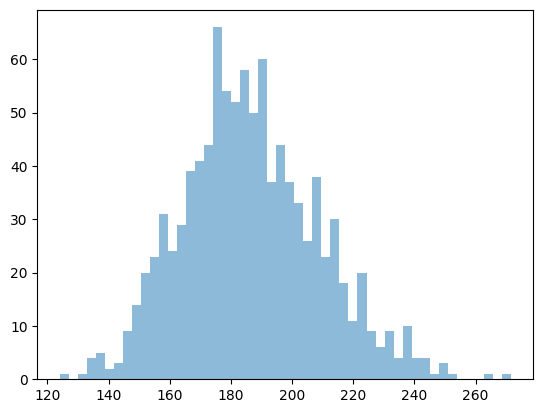

Statistics=0.307, p=0.000
Different distribution (reject H0) : the two samples are drawn from different distributions, i.e. the model is significant.


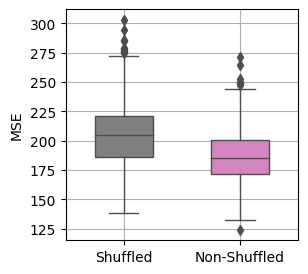

          Shuffled  Non-Shuffled
count  1000.000000   1000.000000
mean    204.770785    186.630869
std      25.534287     22.351257
min     138.458593    124.102339
25%     185.923000    171.530053
50%     204.675155    184.882205
75%     221.378118    200.877008
max     303.060098    271.533889
Network : resnet18


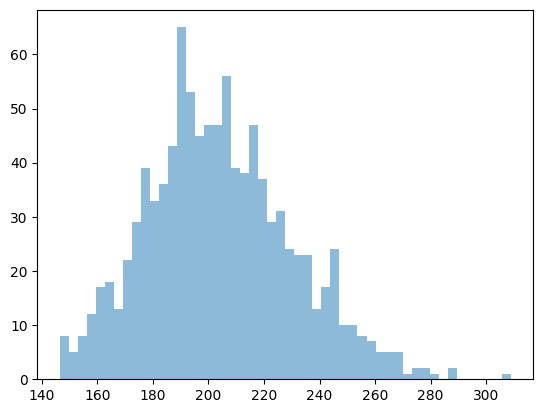

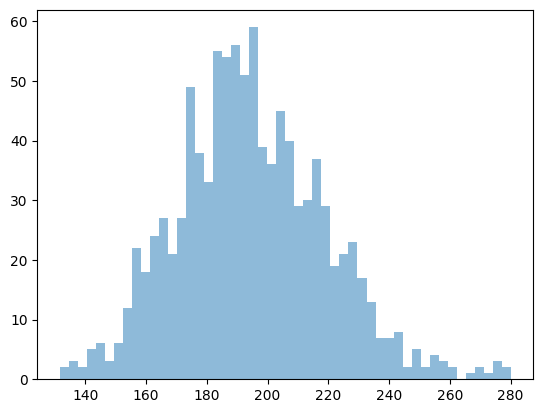

Statistics=0.155, p=0.000
Different distribution (reject H0) : the two samples are drawn from different distributions, i.e. the model is significant.


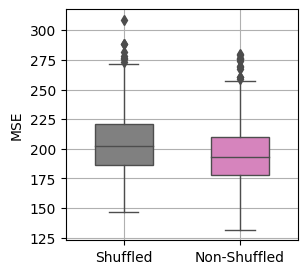

          Shuffled  Non-Shuffled
count  1000.000000   1000.000000
mean    204.176137    194.879251
std      26.210531     24.474445
min     146.532829    131.698725
25%     186.148765    178.153322
50%     202.081738    193.412478
75%     220.747283    210.250289
max     308.838775    280.039234
Network : efficientnetB0


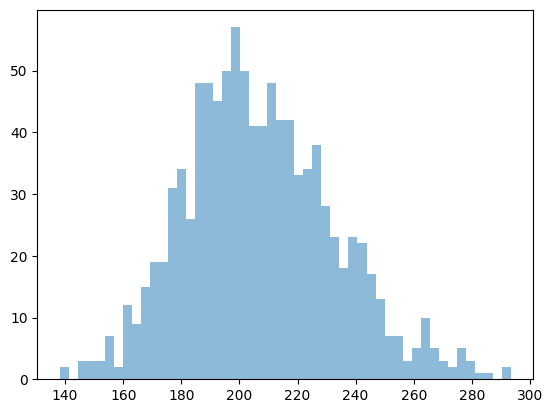

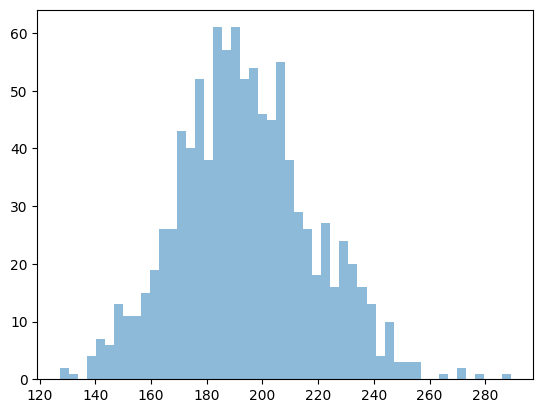

Statistics=0.206, p=0.000
Different distribution (reject H0) : the two samples are drawn from different distributions, i.e. the model is significant.


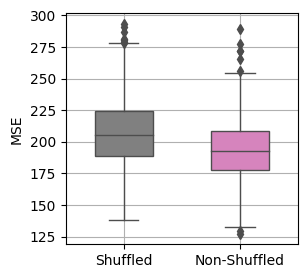

          Shuffled  Non-Shuffled
count  1000.000000   1000.000000
mean    207.050849    193.879131
std      25.805667     24.131554
min     138.199875    127.278826
25%     188.801851    177.532323
50%     205.254870    192.484458
75%     224.467755    208.823602
max     293.419302    289.135763


In [183]:
for network in networks:
    print("Network : " + network)
    plot_histograms(scores[network]["shuffled"], scores[network]["non_shuffled"])
    
    # We obtain 2 distributions of scores : one for shuffled data, one for non-shuffled data
    # We want to know if the samples are obtained from the same distribution
    # We use a two-sample Kolmogorov-Smirnov test to compare the two distributions
    stat, p = ks_2samp(scores[network]["shuffled"], scores[network]["non_shuffled"])
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # Null hypothesis: the two distributions are identical.
    # If the p-value is less than 0.05, we reject the null hypothesis and conclude that the two samples are drawn from different distributions.
    # If the p-value is larger than 0.05, we cannot conclude that the two samples are drawn from different distributions.
    if p > 0.05:
        print("Same distribution (fail to reject H0) : the two samples are drawn from the same distribution, i.e. the model is not significant.")
    else:
        print("Different distribution (reject H0) : the two samples are drawn from different distributions, i.e. the model is significant.")
        # If test passes, discuss certain statistics (mean, median, etc.) to see if they are significantly different to affirm that non-shuffled data is better than shuffled data and that the difference is significant

        # Compute the mean of the two distributions
        mean_shuffled = np.mean(scores[network]["shuffled"])
        mean_non_shuffled = np.mean(scores[network]["non_shuffled"])

        # Compute the median of the two distributions
        median_shuffled = np.median(scores[network]["shuffled"])
        median_non_shuffled = np.median(scores[network]["non_shuffled"])

        # Compute the standard deviation of the two distributions
        std_shuffled = np.std(scores[network]["shuffled"])
        std_non_shuffled = np.std(scores[network]["non_shuffled"])

        # Compute the variance of the two distributions
        var_shuffled = np.var(scores[network]["shuffled"])
        var_non_shuffled = np.var(scores[network]["non_shuffled"])

        # Make a boxplot of the two distributions
        colors = {0: "grey", 1: "C6"}
        figure = plt.figure(figsize=(3, 3))
        sns.boxplot([scores[network]["shuffled"], scores[network]["non_shuffled"]], width = 0.5, linewidth=1, palette=colors)
        plt.xticks([0, 1], ['Shuffled', 'Non-Shuffled'])
        plt.grid()
        plt.ylabel("MSE")
        # put grid behind the bars
        plt.gca().set_axisbelow(True)
        
        plt.savefig("figures/stats/boxplot_" + network + ".jpeg", dpi=300, bbox_inches='tight')
        plt.show()

        # Make a dataframe of the two distributions (summary statistics)import pandas as pd
        df = pd.DataFrame({'Shuffled': scores[network]["shuffled"], 'Non-Shuffled': scores[network]["non_shuffled"]})
        print(df.describe())
        
        scores[network]["df"] = df.describe()


In [185]:
# Make a dataframe with all the summary statistics of the different networks
df = pd.DataFrame()
for network in networks:
    print("Network : " + network)
    print(scores[network]["df"].to_latex())
    # save the dataframe in a tex file
    with open("figures/stats/df_" + network + ".tex", "w") as f:
        f.write(scores[network]["df"].to_latex())

Network : DRTANet_final
\begin{tabular}{lrr}
\toprule
{} &     Shuffled &  Non-Shuffled \\
\midrule
count &  1000.000000 &   1000.000000 \\
mean  &   204.770785 &    186.630869 \\
std   &    25.534287 &     22.351257 \\
min   &   138.458593 &    124.102339 \\
25\%   &   185.923000 &    171.530053 \\
50\%   &   204.675155 &    184.882205 \\
75\%   &   221.378118 &    200.877008 \\
max   &   303.060098 &    271.533889 \\
\bottomrule
\end{tabular}

Network : resnet18
\begin{tabular}{lrr}
\toprule
{} &     Shuffled &  Non-Shuffled \\
\midrule
count &  1000.000000 &   1000.000000 \\
mean  &   204.176137 &    194.879251 \\
std   &    26.210531 &     24.474445 \\
min   &   146.532829 &    131.698725 \\
25\%   &   186.148765 &    178.153322 \\
50\%   &   202.081738 &    193.412478 \\
75\%   &   220.747283 &    210.250289 \\
max   &   308.838775 &    280.039234 \\
\bottomrule
\end{tabular}

Network : efficientnetB0
\begin{tabular}{lrr}
\toprule
{} &     Shuffled &  Non-Shuffled \\
\midrule
coun

/var/folders/9p/n9mxhx3n1791z00xfb621dyc0000gn/T/ipykernel_90739/3759403454.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(scores[network]["df"].to_latex())
/var/folders/9p/n9mxhx3n1791z00xfb621dyc0000gn/T/ipykernel_90739/3759403454.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(scores[network]["df"].to_latex())
